# Predicting time series data using LSTM

In [9]:
# Required imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class TimeSeriesData():
    """
    A Data structure to create my own time series data based on the sine function
    """
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # 1- Random starting point for each batch
        # 2- Convert to be on time series
        # 3- Create batch Time Series on t axis
        rand_start = np.random.rand(batch_size,1) 
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for LSTM
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

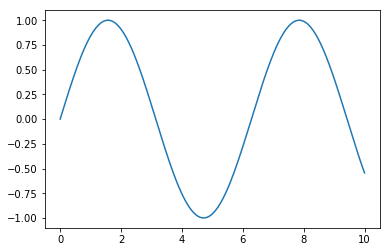

In [4]:
ts_data = TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)

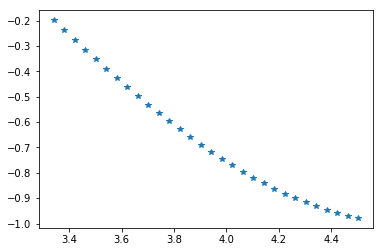

In [7]:
num_time_steps = 30 # Num of steps in batch (also used for prediction steps into the future)
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

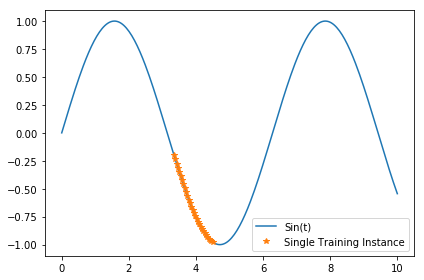

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

## Predict a time series shifted over by t+1

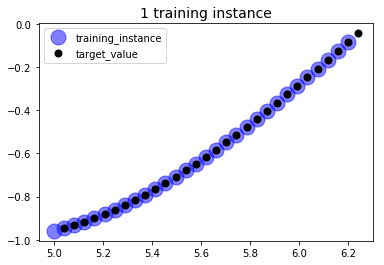

In [29]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)
plt.title("1 training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="training_instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target_value")
plt.legend()

## Model Architecture

In [30]:
tf.reset_default_graph()
num_inputs = 1     # Just one feature, the time series
num_neurons = 100  # 100 neuron layer, play with this
num_outputs = 1    # Just one output, predicted time series

learning_rate = 0.0001
num_train_iterations = 5000
batch_size = 1

X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [31]:
# I'm using an basic LSTM cell

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [32]:
# Optimizing the MSE loss and training using Adam optimizer

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [33]:
# Tensorflow graph execution

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./saved_model/lstm_time_series_model_5000")

0 	MSE: 0.784803
100 	MSE: 0.264258
200 	MSE: 0.0583438
300 	MSE: 0.0735313
400 	MSE: 0.0399015
500 	MSE: 0.0255346
600 	MSE: 0.12212
700 	MSE: 0.117618
800 	MSE: 0.0667241
900 	MSE: 0.0436595
1000 	MSE: 0.0145889
1100 	MSE: 0.0781963
1200 	MSE: 0.00469046
1300 	MSE: 0.0511187
1400 	MSE: 0.0443851
1500 	MSE: 0.0220056
1600 	MSE: 0.0291569
1700 	MSE: 0.00753575
1800 	MSE: 0.0214537
1900 	MSE: 0.0173349
2000 	MSE: 0.00418367
2100 	MSE: 0.0256
2200 	MSE: 0.0300846
2300 	MSE: 0.021425
2400 	MSE: 0.00859947
2500 	MSE: 0.0326867
2600 	MSE: 0.0104991
2700 	MSE: 0.0178211
2800 	MSE: 0.00730027
2900 	MSE: 0.010456
3000 	MSE: 0.0323382
3100 	MSE: 0.0190519
3200 	MSE: 0.00881667
3300 	MSE: 0.0165011
3400 	MSE: 0.0146516
3500 	MSE: 0.0206942
3600 	MSE: 0.00619491
3700 	MSE: 0.0019939
3800 	MSE: 0.00105638
3900 	MSE: 0.00838526
4000 	MSE: 0.00348748
4100 	MSE: 0.0103597
4200 	MSE: 0.0207311
4300 	MSE: 0.00836967
4400 	MSE: 0.0170943
4500 	MSE: 0.00397168
4600 	MSE: 0.00643842
4700 	MSE: 0.0155186
4

# Final prediction

In [34]:
## To predict the next time step

with tf.Session() as sess:                          
    saver.restore(sess, "./saved_model/lstm_time_series_model_5000")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./saved_model/lstm_time_series_model_5000


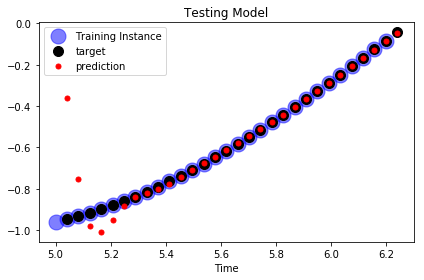

In [35]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()